In [2]:
import numpy as np
import pandas as pd
import dowhy
from dowhy import CausalModel
import networkx as nx

In [3]:
df = pd.read_csv("bpi2017_final.csv")
print(df.columns)
df.head()

Index(['case:concept:name', 'NumberOfOffers', 'Action', 'org:resource',
       'concept:name', 'EventOrigin', 'lifecycle:transition', 'time:timestamp',
       'case:LoanGoal', 'case:ApplicationType', 'case:RequestedAmount',
       'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost',
       'Selected', 'CreditScore', 'OfferedAmount', 'treatedCase',
       'caseSuccesful', 'treatmentSuccess', 'offerNumber', 'offerSuccess',
       'treatmentOffer', 'timeApplication', 'weekdayApplication'],
      dtype='object')


,case:concept:name,NumberOfOffers,Action,org:resource,concept:name,EventOrigin,lifecycle:transition,time:timestamp,case:LoanGoal,case:ApplicationType,...,CreditScore,OfferedAmount,treatedCase,caseSuccesful,treatmentSuccess,offerNumber,offerSuccess,treatmentOffer,timeApplication,weekdayApplication
0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,651433.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000,2.0
1,0.0,1.0,4.0,0.0,8.0,0.0,1.0,651434.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.061,2.0
2,0.0,1.0,0.0,0.0,22.0,2.0,3.0,651435.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,0.290,2.0
3,0.0,1.0,1.0,0.0,22.0,2.0,6.0,651437.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,66.613,2.0
4,0.0,1.0,0.0,0.0,21.0,2.0,3.0,651438.0,10.0,1.0,...,0.0,5000.0,0.0,0.0,0.0,1.0,0.0,0.0,66.620,2.0


In [4]:
#decide on features based on dot_graph
treatment=df['treatmentOffer']
features = df[['NumberOfOffers', 'Action', 'org:resource',
       'concept:name', 'EventOrigin', 'lifecycle:transition', 'time:timestamp',
       'case:LoanGoal', 'case:ApplicationType', 'case:RequestedAmount',
       'FirstWithdrawalAmount', 'NumberOfTerms', 'Accepted', 'MonthlyCost', 'Selected',
       'CreditScore', 'OfferedAmount', 'offerNumber','timeApplication', 'weekdayApplication']]
y=df['offerSuccess']

In [5]:
dot_graph = nx.DiGraph ([('treatmentOffer', 'offerSuccess'), ('treatmentOffer', 'timeApplication'), ('treatmentOffer', 'NumberOfOffers'), ('treatmentOffer', 'org:resource'), ('offerNumber', 'treatmentOffer'), ('org:resource', 'OfferedAmount'), ('case:RequestedAmount', 'org:resource'),
                         ('offerNumber', 'timeApplication'), ('NumberOfOffers', 'OfferedAmount'),  ('OfferedAmount', 'MonthlyCost'), ('OfferedAmount', 'FirstWithdrawalAmount'), ('OfferedAmount', 'NumberOfTerms'), ('case:RequestedAmount', 'OfferedAmount'), 
                         ('case:ApplicationType', 'FirstWithdrawalAmount'), ('CreditScore', 'FirstWithdrawalAmount'), ('CreditScore', 'case:ApplicationType'), ('CreditScore', 'offerSuccess'), ('CreditScore', 'Selected'), ('Selected', 'offerSuccess'),
                         ('case:LoanGoal', 'case:RequestedAmount'), ('case:LoanGoal', 'timeApplication'), ('timeApplication', 'case:RequestedAmount'), ('timeApplication', 'NumberOfTerms'), ('NumberOfOffers', 'offerSuccess')])

In [6]:
model = CausalModel(
   data=df, # some pandas dataframe
   treatment='treatmentOffer',
   outcome='offerSuccess',
   graph="\n".join(nx.generate_gml(dot_graph))
)

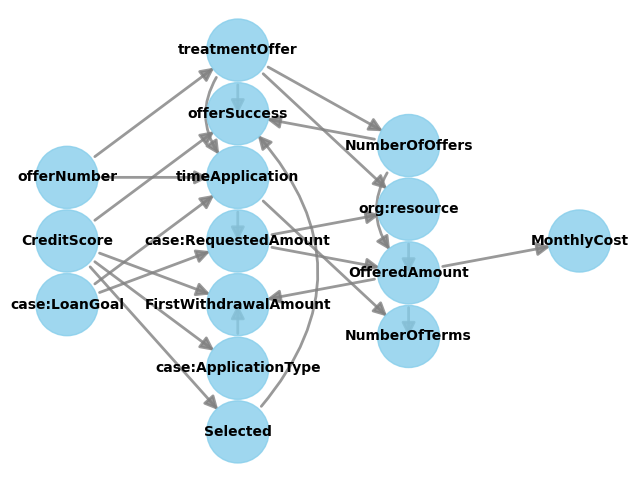

In [7]:
model.view_model()

In [8]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                         
─────────────────(E[offerSuccess])
d[treatmentOffer]                 
Estimand assumption 1, Unconfoundedness: If U→{treatmentOffer} and U→offerSuccess then P(offerSuccess|treatmentOffer,,U) = P(offerSuccess|treatmentOffer,)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                               -1⎤
 ⎢      d                      ⎛      d                         ⎞  ⎥
E⎢──────────────(offerSuccess)⋅⎜──────────────([treatmentOffer])⎟  ⎥
 ⎣d[offerNumber]               ⎝d[offerNumber]                  ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→offerSuccess then ¬(U →→{offerNumber})
Estimand assumption 2, Exclusion: If we remove {offerNumber}→{treatmentOffer}, then ¬({offerNumber}→offerSuccess)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Regression

In [11]:
# Run a linear regression of column successful on treatment in df
import statsmodels.api as sm

t = df['treatmentOffer'].astype(int)
y = df['offerSuccess'].astype(int)

t = sm.add_constant(t)

ols = sm.OLS(y, t).fit()

# Display a more parsimonious results summary
print(ols.summary().tables[1])

                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.4928      0.000   1001.087      0.000       0.492       0.494
treatmentOffer     0.1375      0.001    107.425      0.000       0.135       0.140


In [12]:
linear_estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate)

/pfs/data5/home/ma/ma_ma/ma_mskiera/dowhy/lib/python3.9/site-packages/dowhy/causal_estimator.py:236: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
/pfs/data5/home/ma/ma_ma/ma_mskiera/dowhy/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/pfs/data5/home/ma/ma_ma/ma_mskiera/dowhy/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a futu

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                         
─────────────────(E[offerSuccess])
d[treatmentOffer]                 
Estimand assumption 1, Unconfoundedness: If U→{treatmentOffer} and U→offerSuccess then P(offerSuccess|treatmentOffer,,U) = P(offerSuccess|treatmentOffer,)

## Realized estimand
b: offerSuccess~treatmentOffer+treatmentOffer*Selected+treatmentOffer*CreditScore
Target units: 

## Estimate
Mean value: 0.07439631020206672
### Conditional Estimates
__categorical__Selected  __categorical__CreditScore
(-0.001, 1.0]            (-0.001, 799.0]              -0.186439
                         (799.0, 923.0]                0.419713
                         (923.0, 1145.0]               0.514705
dtype: float64


In [ ]:
res_cause_lr=model.refute_estimate(identified_estimand, linear_estimate, method_name="random_common_cause")
print("Refute Estimate for random common cause of Linear Regression: ", res_cause_lr)

res_placebo_lr=model.refute_estimate(identified_estimand, linear_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print("Refute Estimate for placebo treatment of Linear Regression: ", res_placebo_lr)

res_subset_lr = model.refute_estimate(
                                    identified_estimand,
                                    linear_estimate,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8)
print("Refute Estimate for random subset remove of Linear Regression: ",res_subset_lr)

### Double ML

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
simple_dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(simple_dml_estimate)

/pfs/data5/home/ma/ma_ma/ma_mskiera/dowhy/lib64/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/pfs/data5/home/ma/ma_ma/ma_mskiera/dowhy/lib64/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
 

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                         
─────────────────(E[offerSuccess])
d[treatmentOffer]                 
Estimand assumption 1, Unconfoundedness: If U→{treatmentOffer} and U→offerSuccess then P(offerSuccess|treatmentOffer,,U) = P(offerSuccess|treatmentOffer,)

## Realized estimand
b: offerSuccess~treatmentOffer | Selected,CreditScore
Target units: 

## Estimate
Mean value: 0.05166971350572673
Effect estimates: [[0.18444912]
 [0.18444912]
 [0.18444912]
 ...
 [0.00779469]
 [0.00779469]
 [0.00779469]]



In [ ]:
res_cause_dml=model.refute_estimate(identified_estimand, simple_dml_estimate, method_name="random_common_cause")
print("Refute Estimate for random common cause of Simple DML: ", res_cause_dml)

res_placebo_dml=model.refute_estimate(identified_estimand, simple_dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print("Refute Estimate for placebo treatment of Simple DML: ", res_placebo_dml)

res_subset_dml = model.refute_estimate(
                                    identified_estimand,
                                    simple_dml_estimate,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8)
print("Refute Estimate for random subset remove of Simple DML: ",res_subset_dml)

### IPW Weighting

In [16]:
#Vanilla Inverse Propensity Score weighting (IPS)
causal_estimate_ipw = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_weight"})
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

/pfs/data5/home/ma/ma_ma/ma_mskiera/dowhy/lib64/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/pfs/data5/home/ma/ma_ma/ma_mskiera/dowhy/lib64/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                 
────────────(E[successful|CreditScore])
d[treatment]                           
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→successful then P(successful|treatment,CreditScore,U) = P(successful|treatment,CreditScore)

## Realized estimand
b: successful~treatment+CreditScore
Target units: ate

## Estimate
Mean value: 0.183595818494109

Causal Estimate is 0.183595818494109


In [17]:
#Self-normalized IPS weighting (also known as the Hajek estimator)
ipw_hajek = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_normalized_weight"})
print(ipw_hajek)
print("IPW Hajek Causal Estimate is " + str(ipw_hajek.value))

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                 
────────────(E[successful|CreditScore])
d[treatment]                           
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→successful then P(successful|treatment,CreditScore,U) = P(successful|treatment,CreditScore)

## Realized estimand
b: successful~treatment+CreditScore
Target units: ate

## Estimate
Mean value: 0.1835958184941091

IPW Hajek Causal Estimate is 0.1835958184941091
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                 
────────────(E[successful|CreditScore])
d[treatment]                           
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→successful then P(successful|treatment,CreditScore,U) = P

In [ ]:
#Stabilized IPS weighting
ipw_stabilized = model.estimate_effect(identified_estimand,
                                            method_name="backdoor.propensity_score_weighting",
                                            target_units = "ate",
                                            method_params={"weighting_scheme":"ips_stabilized_weight"})
print(ipw_stabilized)
print("IPW Stabilized Causal Estimate is " + str(ipw_stabilized.value))

### Method: Matching

Propensity Score Matching

In [15]:
causal_estimate_match = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.propensity_score_matching",
                                              target_units="ate")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

/pfs/data5/home/ma/ma_ma/ma_mskiera/dowhy/lib64/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/pfs/data5/home/ma/ma_ma/ma_mskiera/dowhy/lib64/python3.9/site-packages/sklearn/utils/validation.py:623: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
        d                                     
─────────────────(E[offerSuccess|CreditScore])
d[treatmentOffer]                             
Estimand assumption 1, Unconfoundedness: If U→{treatmentOffer} and U→offerSuccess then P(offerSuccess|treatmentOffer,CreditScore,U) = P(offerSuccess|treatmentOffer,CreditScore)

## Realized estimand
b: offerSuccess~treatmentOffer+CreditScore
Target units: ate

## Estimate
Mean value: -0.030568654924106185

Causal Estimate is -0.030568654924106185


Distance Matching: Define a distance metric and then use the metric to match closest points between treatment and control.

In [ ]:
causal_estimate_dmatch = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.distance_matching",
                                              target_units="att",
                                              method_params={'distance_metric':"minkowski", 'p':2})
print(causal_estimate_dmatch)
print("Causal Estimate is " + str(causal_estimate_dmatch.value))

In [16]:
causal_estimate_dmatch = model.estimate_effect(identified_estimand,
                                              method_name="backdoor.distance_matching",
                                              target_units="ate",
                                              method_params={'distance_metric':"minkowski", 'p':2})
print(causal_estimate_dmatch)
print("Causal Estimate is " + str(causal_estimate_dmatch.value))

KeyboardInterrupt: 

## Refute the obtained estimate using multiple robustness checks.
- Add random cause
- Add placebo treatment
- Remove Random Subset of Data

In [ ]:
res_cause_ipw=model.refute_estimate(identified_estimand, causal_estimate_ipw, method_name="random_common_cause")
print("Refute Estimate for random common cause of IPW: ", res_cause_ipw)

res_placebo_ipw=model.refute_estimate(identified_estimand, causal_estimate_ipw,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print("Refute Estimate for placebo treatment of IPW: ", res_placebo_ipw)

res_subset_ipw = model.refute_estimate(
                                    identified_estimand,
                                    causal_estimate_ipw,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8)
print("Refute Estimate for random subset remove of IPW: ",res_subset_ipw)

In [ ]:
res_cause_ipw_hajek=model.refute_estimate(identified_estimand, ipw_hajek, method_name="random_common_cause")
print("Refute Estimate for random common cause of IPW Hajek: ", res_cause_ipw_hajek)

res_placebo_ipw_hajek=model.refute_estimate(identified_estimand, ipw_hajek,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print("Refute Estimate for placebo treatment of IPW Hajek: ", res_placebo_ipw_hajek)

res_subset_ipw_hajek = model.refute_estimate(
                                    identified_estimand,
                                    ipw_hajek,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8)
print("Refute Estimate for random subset remove of IPW Hajek: ",res_subset_ipw_hajek)

In [ ]:
res_cause_ipw_stabilized=model.refute_estimate(identified_estimand, causal_estimate_ipw_stabilized, method_name="random_common_cause")
print("Refute Estimate for random common cause of IPW Stabilized: ", res_cause_ipw_stabilized)

res_placebo_ipw_stabilized=model.refute_estimate(identified_estimand, causal_estimate_ipw_stabilized,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print("Refute Estimate for placebo treatment of IPW Stabilized: ", res_placebo_ipw_stabilized)

res_subset_ipw_stabilized = model.refute_estimate(
                                    identified_estimand,
                                    causal_estimate_ipw_stabilized,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8)
print("Refute Estimate for random subset remove of IPW Stabilized: ",res_subset_ipw_stabilized)

In [ ]:
res_cause_match=model.refute_estimate(identified_estimand, causal_estimate_match, method_name="random_common_cause")
print("Refute Estimate for random common cause of Propensity Score Matching: ", res_cause_match)

res_placebo_match=model.refute_estimate(identified_estimand, causal_estimate_match,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print("Refute Estimate for placebo treatment of Propensity Score Matching: ", res_placebo_match)

res_subset_match = model.refute_estimate(
                                    identified_estimand,
                                    causal_estimate_match,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8)
print("Refute Estimate for random subset remove of Propensity Score Matching: ",res_subset_match)

In [ ]:
res_cause_dmatch=model.refute_estimate(identified_estimand, causal_estimate_dmatch, method_name="random_common_cause")
print("Refute Estimate for random common cause of Distance Matching: ", res_cause_dmatch)

res_placebo_dmatch=model.refute_estimate(identified_estimand, causal_estimate_dmatch,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print("Refute Estimate for placebo treatment of Distance Matching: ", res_placebo_dmatch)

res_subset_dmatch = model.refute_estimate(
                                    identified_estimand,
                                    causal_estimate_dmatch,
                                    method_name="data_subset_refuter",
                                    subset_fraction=0.8)
print("Refute Estimate for random subset remove of Distance Matching: ",res_subset_dmatch)

### Add results to Result-Dataframe

In [ ]:
result_list = {'Method': ['Linear Regression', 'Double ML'],
        'ATE': [linear_estimate.value, simple_dml_estimate.value],
        'ITE': ['', simple_dml_estimate.cate_estimates]}

In [ ]:
%store -r df_results
dowhy = "DoWhy"

if 'Linear Regression' in df_results['method'].values:
    # If 'ipw' exists, overwrite the 'ATE' column with ipw_ate_result
    df_results.loc[df_results['method'] == 'Linear Regression', ['ATE', 'Library']] = linear_estimate.value, dowhy
else:
    # If 'ipw' doesn't exist, add a new row with method='ipw' and ATE=ipw_ate_result
    df_results = df_results._append({'method': 'Linear Regression', 'ATE': linear_estimate.value}, ignore_index=True)



df_results

In [ ]:
%store df_results

In [ ]:
evaluation_list = {'Method': [], 
                   'Placebo': [],
                   'Common Cause': [],
                   'Random Subset': [],
                   'Random Replacement': []}